In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import lumped_parameter_model
import utils 
importlib.reload(lumped_parameter_model)
importlib.reload(utils)
from lumped_parameter_model import *
from utils import *
from scipy import optimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## Simple Drainage

In [2]:
A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
kbar = 1000. #m/d
b = 20.
hs = 372.5 #m
sy = 0.2
dt = 1. 
model = Model(w=w, l = l, kbar =kbar, b = b, hs = hs, sy = sy, dt = dt)

<Axes: xlabel='Date', ylabel='Q [m3/day]'>

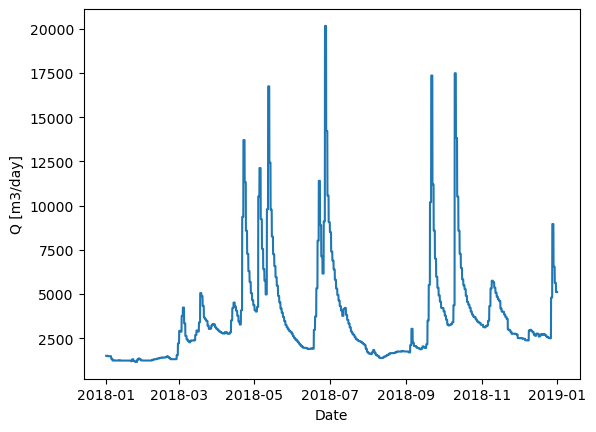

In [3]:
#load observed discharge
dis_data_path = 'discharge_full_year_2018.csv'
obs_dis = convert_df_to_date_time(pd.read_csv(dis_data_path), 'Date')

#get hourly timestamps
hourly_obs_dis = convert_daily_to_hourly(obs_dis, 'Date')
sns.lineplot(hourly_obs_dis, x = 'Date', y = 'Q [m3/day]')

In [4]:
# load hourly recharge from Charlie
recharge_data_path = "2017_2021_simulated_recharge_hourly.csv"
rech = convert_df_to_date_time(pd.read_csv(recharge_data_path), 'DATE') #load data
rech = rech[(rech['DATE'] <= '12-31-2018') & (rech['DATE'] >= '01-01-2018')].reset_index(drop=True) #filter date range
rech['RCH[m3/d]'] = rech['RCH[m3/s]'] * 86400
daily_rech = convert_hourly_to_daily(rech, 'DATE') #get daily recharge values with median values of recharge
# daily_rech['RCH[m3/d]'] = daily_rech['RCH[m3/s]'] * 86400

In [5]:
#Load modflow discharge data
mf_data_path = 'bearDis.csv'
mf_data = convert_df_to_date_time(pd.read_csv(mf_data_path), 'DATETIME')

In [5]:
obs_head_path = '2018_MRSW_year_FINAL.csv'
obs_head = convert_df_to_date_time(pd.read_csv(obs_head_path), 'datetime')
hourly_obs_head = convert_daily_to_hourly(obs_head, 'datetime')
hourly_obs_head = hourly_obs_head[hourly_obs_head['gw_elev[m]'] > hourly_obs_head.quantile(.05)['gw_elev[m]']]

In [7]:
#optimize
def objective(args, h0, r_data, val_data, error_fun): #give recharge data and observed data (validation)
    K = args[0]
    model_out = model.explicit_solve_over_time(len(r_data), h0 = h0, r =  r_data, kbar = K)
    model_dis = model_out['head']
    error = error_fun(val_data, model_dis)
    print(error)
    return error
params = (kbar)
val_data = hourly_obs_head[hourly_obs_head['datetime'].isin(rech['DATE'])]['gw_elev[m]']
result = optimize.minimize(objective,params, args = (model.hs, rech['RCH[m/day]'], val_data, mean_absolute_percentage_error))

ValueError: Input contains NaN.

In [32]:
kbar = result.x[0] 
sy = result.x[1]
calibrated_results = model.explicit_solve_over_time(len(rech['RCH[m3/d]']), h0 = hinit, r =  -1 * rech['RCH[m/day]'], kbar = kbar, sy = sy)

NameError: name 'result' is not defined

In [220]:
print(f"K: {kbar}, Sy: {sy}")

K: 1000.0, Sy: 0.2


qs: 0.0, qin: 1345.61328, h: 372.51446896
qs: 57.87583999995149, qin: 1345.3119599999998, h: 372.52831235913976
qs: 113.24943655904461, qin: 1345.01064, h: 372.5415571032628
qs: 166.22841305115796, qin: 1344.7093199999997, h: 372.55422894097194
qs: 216.915763887755, qin: 1344.4079999999997, h: 372.5663525134033
qs: 265.4100536130954, qin: 1344.1066799999996, h: 372.577951401859
qs: 311.80560743609925, qin: 1343.8053599999998, h: 372.589048173392
qs: 356.1926935678911, qin: 1343.5040399999998, h: 372.59966442442885
qs: 398.6576977154072, qin: 1343.2027199999998, h: 372.6098208225179
qs: 439.28329007167116, qin: 1342.9014, h: 372.6195371462806
qs: 478.14858512242597, qin: 1342.60008, h: 372.6288323236449
qs: 515.3292945794873, qin: 1342.29876, h: 372.6377244684343
qs: 550.8978737373126, qin: 1341.9955799999998, h: 372.6462308953834
qs: 584.9235815335304, qin: 1341.69426, h: 372.6543682145067
qs: 617.4728580267582, qin: 1341.3929399999997, h: 372.6621523014096
qs: 648.6092056384222, qin: 

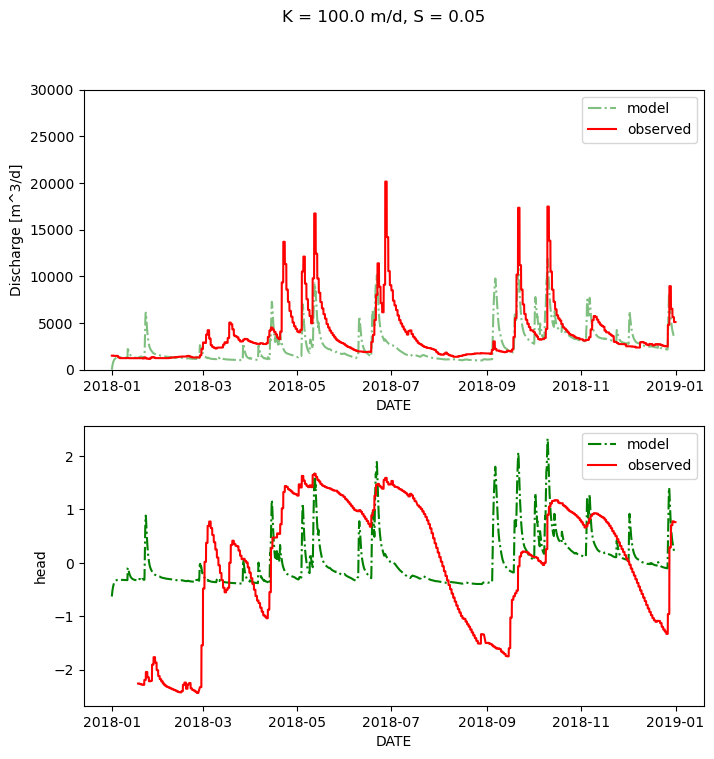

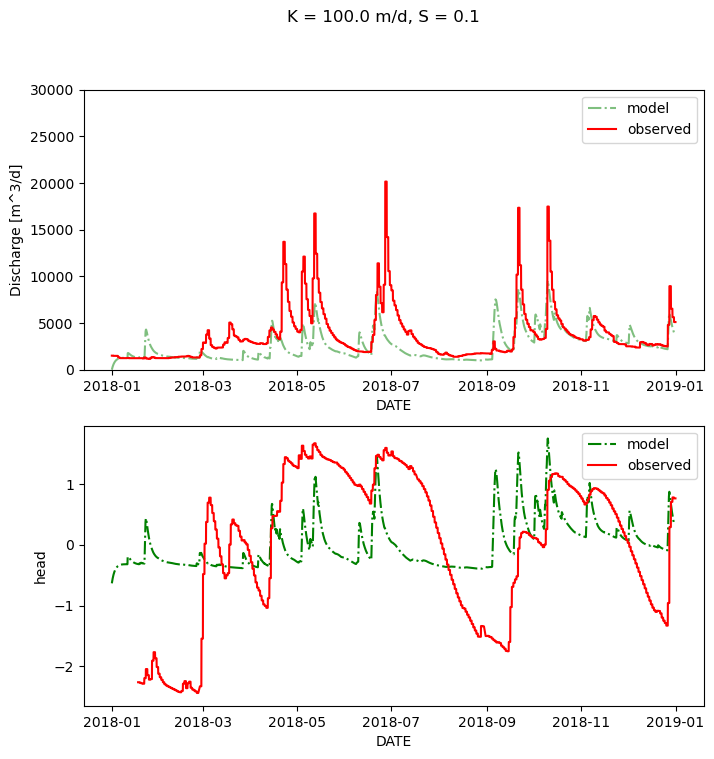

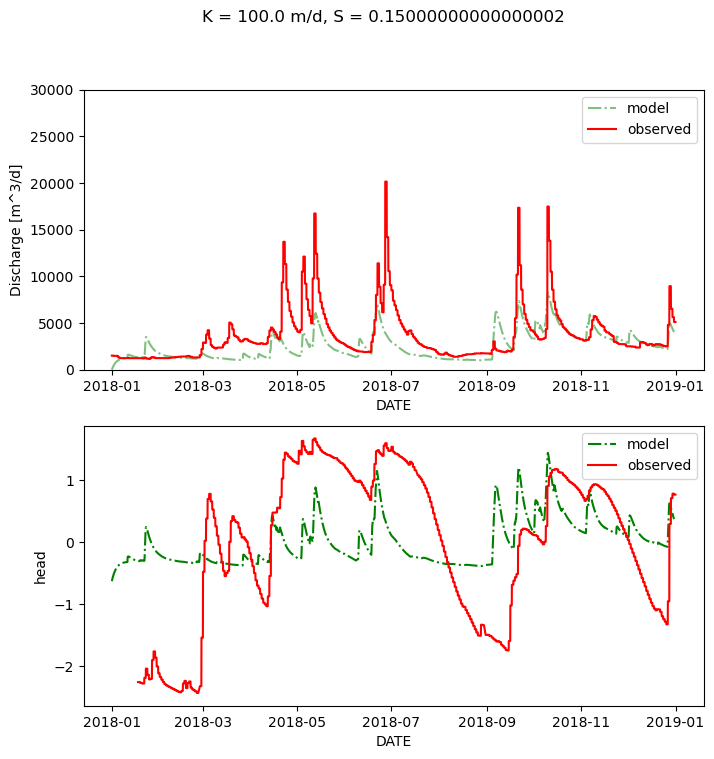

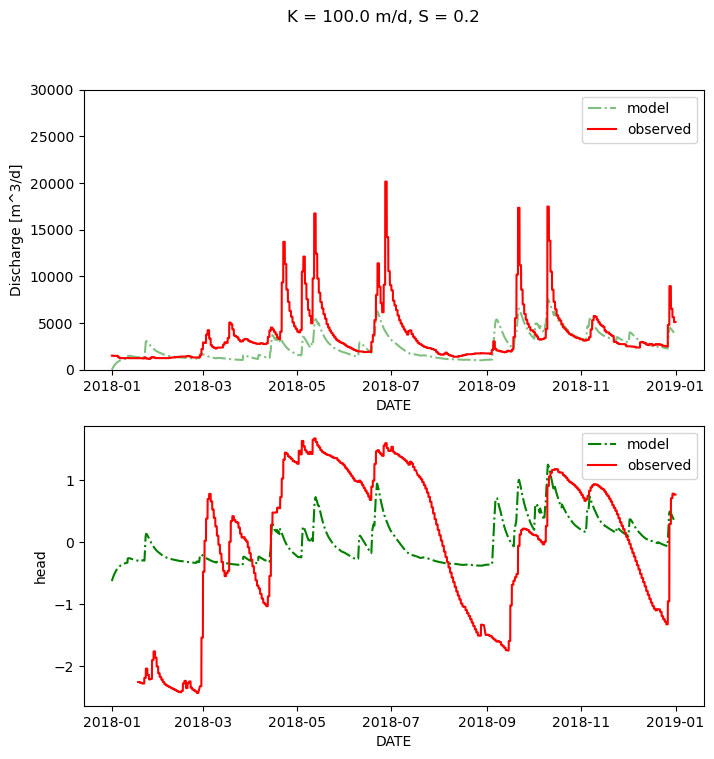

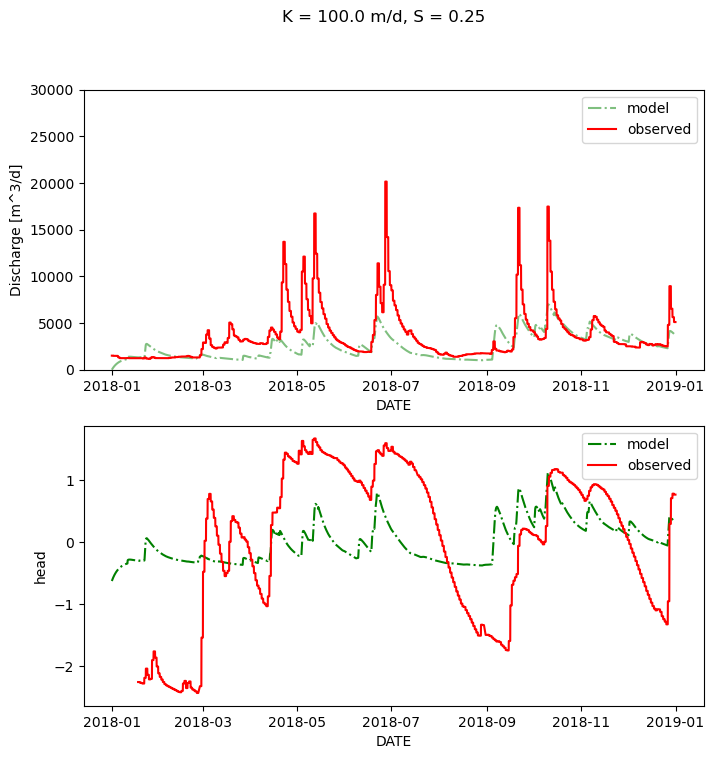

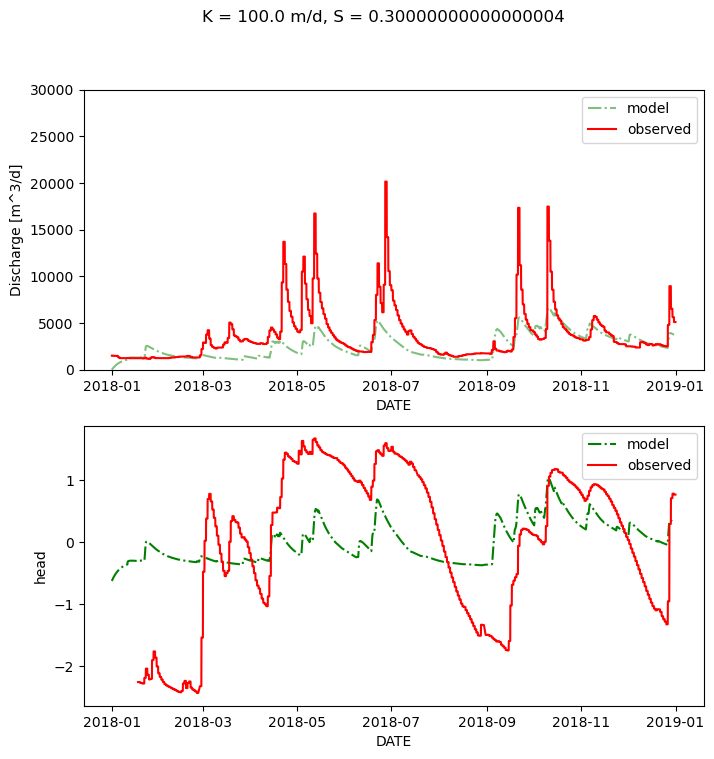

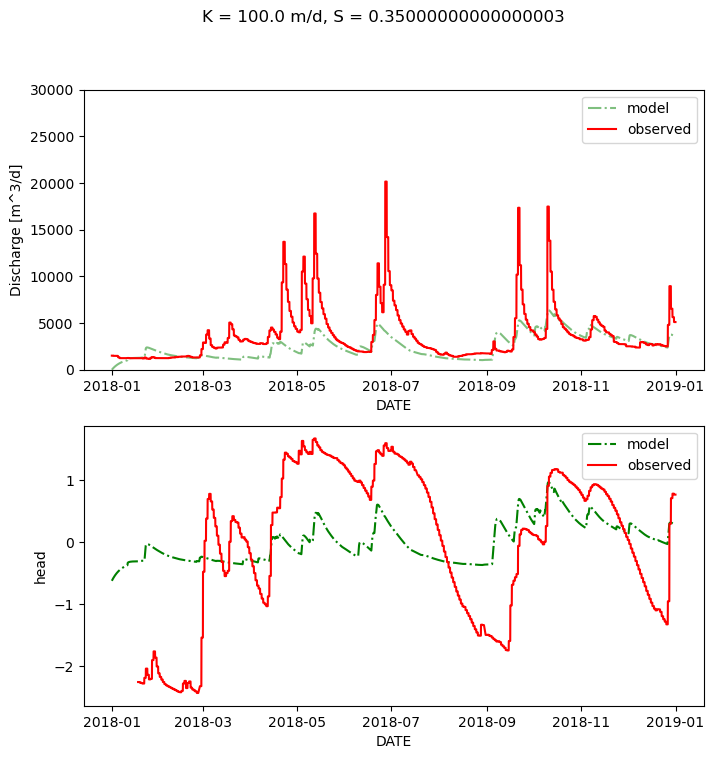

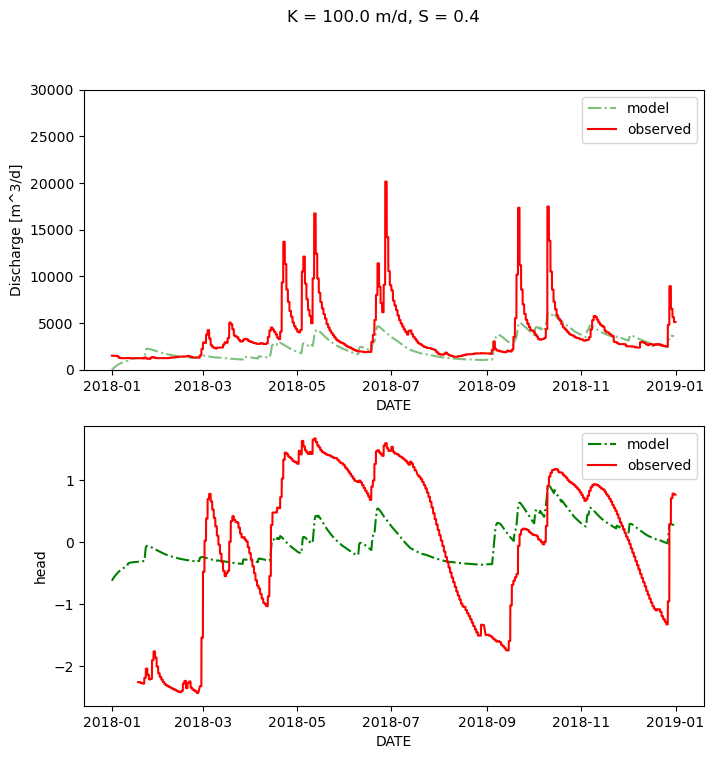

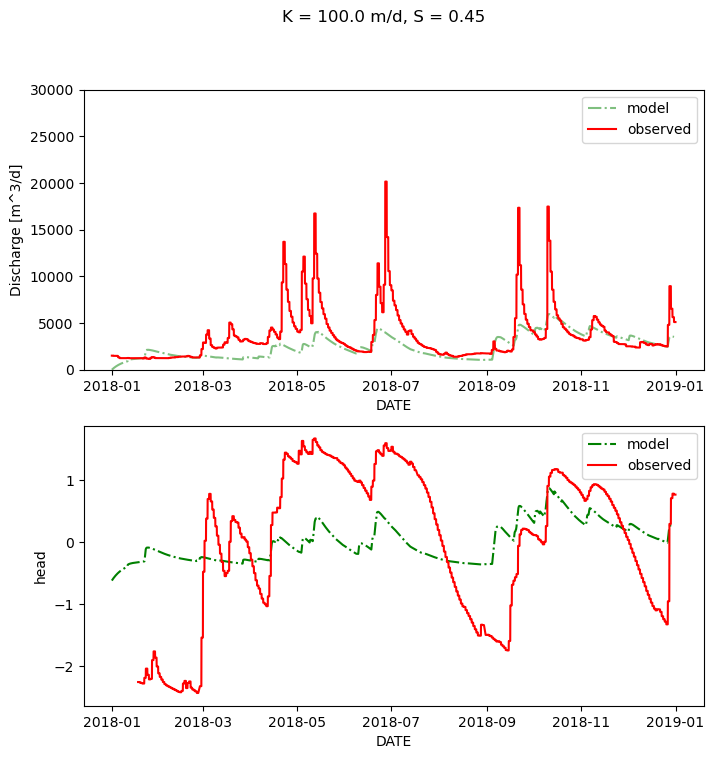

In [10]:
ks = np.arange(1, 2) * 100
sys = np.arange(1, 10) * 0.05

# Create grid of ks and sys values
K, S = np.meshgrid(ks, sys)

# Flatten the arrays to get pairs of values
combinations = np.column_stack([K.ravel(), S.ravel()])

for k, sy in combinations: 
    results_18 = model.explicit_solve_over_time(rech.shape[0], model.hs,  rech['RCH[m/day]'], kbar = k, sy = sy, verbose = True)
    fig, ax = plt.subplots(2, 1, figsize= (8,8))
    sns.lineplot(y = results_18['discharge'], x = rech['DATE'], label = 'model', ax = ax[0], color = 'green', linestyle = '-.', alpha = 0.5)
    sns.lineplot(hourly_obs_dis, x = 'Date', y = 'Q [m3/day]', label = 'observed', ax = ax[0], color = 'red')
    ax[0].set_ylabel('Discharge [m^3/d]')
    ax[0].set_ylim(0,30000)
    sns.lineplot(data = results_18, x = rech['DATE'], y = results_18['head'] -results_18['head'].mean() , label = 'model', ax =ax[1], color = 'green', linestyle = '-.')
    sns.lineplot(x = hourly_obs_head['datetime'], y = hourly_obs_head['gw_elev[m]'] - hourly_obs_head['gw_elev[m]'].mean(), label = 'observed', ax= ax[1], color = 'red')
    plt.suptitle(f"K = {k} m/d, S = {sy}")



NameError: name 'calibrated_results' is not defined

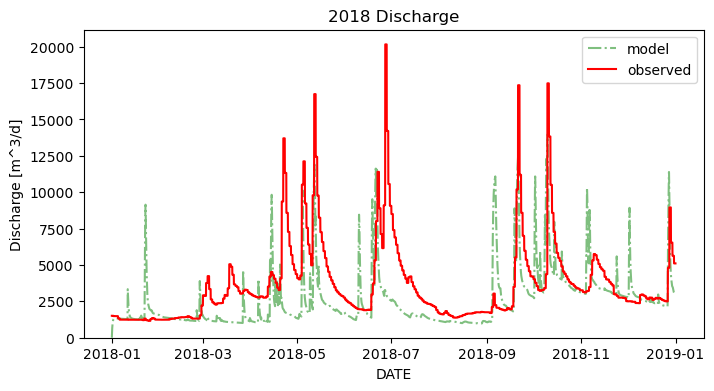

In [ ]:
fig, ax = plt.subplots(figsize= (8,4))
sns.lineplot(y = results_18['discharge'], x = rech['DATE'], label = 'model', ax = ax, color = 'green', linestyle = '-.', alpha = 0.5)
sns.lineplot(hourly_obs_dis, x = 'Date', y = 'Q [m3/day]', label = 'observed', ax = ax, color = 'red')
ax.set_ylabel('Discharge [m^3/d]')
plt.ylim([0, None])
plt.title("2018 Discharge")
# sns.lineplot(y = calibrated_results['discharge'], x = rech['DATE'], label = 'calibrated', ax = ax, color = 'blue', linestyle = '-.', alpha = 0.5)
# sns.lineplot(calibrated_results, x = rech['DATE'], y = 'head', label = 'head', ax = ax.twinx(), color = 'red')
plt.savefig('figs/calibrated_vs_obs_discharge.png', bbox_inches = 'tight')


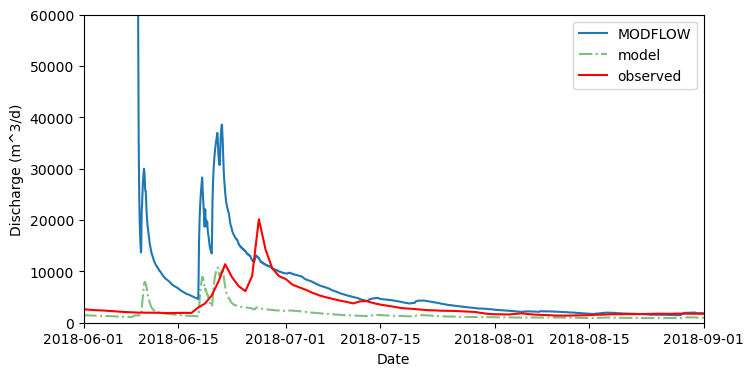

In [200]:
fig, ax = plt.subplots(figsize= (8,4))
sns.lineplot(mf_data, x = 'DATETIME', y = 'BearSpringDischarge[m3/day]', label = 'MODFLOW', ax = ax)
sns.lineplot(y = results_18['discharge'], x = rech['DATE'], label = 'model', ax = ax, color = 'green', linestyle = '-.', alpha = 0.5)
sns.lineplot(obs_dis, x = 'Date', y = 'Q [m3/day]', label = 'observed', ax = ax, color = 'red')
ax.set_xlim([pd.to_datetime('06-01-2018'), pd.to_datetime('09-01-2018')])
ax.set_ylim([0, 60000])
plt.xlabel("Date")
plt.ylabel("Discharge (m^3/d)")
plt.savefig('figs/discharge_mf_vs_model.png', bbox_inches = 'tight')



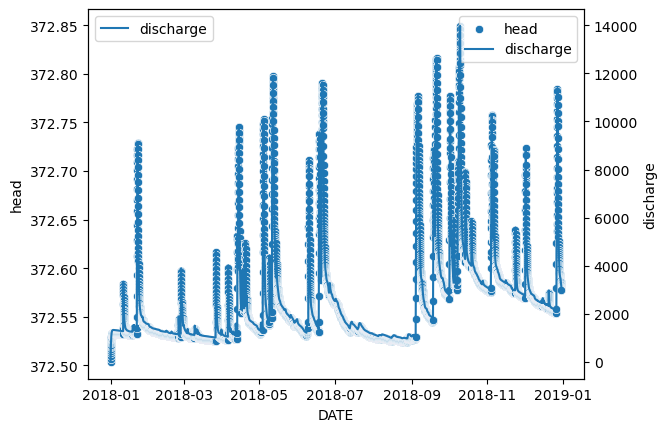

In [51]:
# sns.scatterplot(hourly_obs_head, x = 'datetime', y = 'gw_elev[m]')
fig, ax = plt.subplots()
twinax = ax.twinx()
sns.scatterplot(data = results_18, x = rech['DATE'], y = 'head', label = 'head', ax = ax)
sns.lineplot(data = results_18, x = rech['DATE'], y = 'discharge', ax = twinax, label = 'discharge')
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = twinax.get_legend_handles_labels()
# Combine legends and place them properly
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper right")


Text(0.5, 1.0, 'Observed Discharge and Groundwater levels')

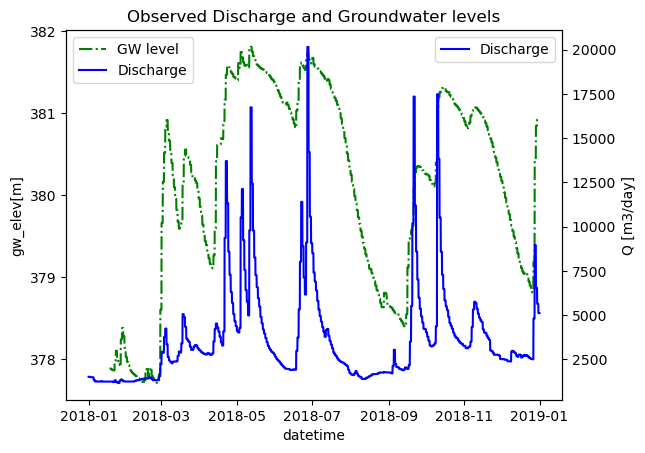

In [55]:
fig, ax = plt.subplots()
twinax = ax.twinx()
sns.lineplot(x = hourly_obs_head['datetime'], y = hourly_obs_head['gw_elev[m]'], label = 'GW level', ax= ax, linestyle = '-.', color = 'green')
sns.lineplot(data = hourly_obs_dis, x = 'Date', y = 'Q [m3/day]', label = 'Discharge', ax = twinax, color = 'blue')
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = twinax.get_legend_handles_labels()
# Combine legends and place them properly
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left")
plt.title("Observed Discharge and Groundwater levels")


<Axes: xlabel='datetime', ylabel='gw_elev[m]'>

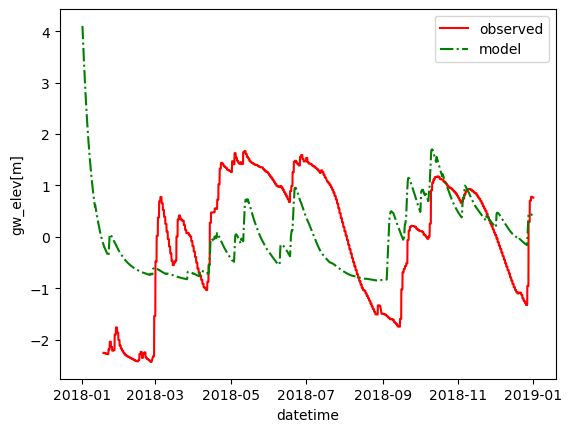

In [57]:
fig, ax = plt.subplots()
sns.lineplot(x = hourly_obs_head['datetime'], y = hourly_obs_head['gw_elev[m]'] - hourly_obs_head['gw_elev[m]'].mean(), label = 'observed', ax= ax, color = 'red')
sns.lineplot(data = results_18, x = rech['DATE'], y = results_18['head'] -results_18['head'].mean() , label = 'model', ax =ax, color = 'green', linestyle = '-.')
